# Setup

In [1]:
#!pip install -q modelscan
!modelscan -v

modelscan, version 0.8.0


2024-09-16 17:28:57.134797: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 17:28:58.066700: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
!pip install -q tensorflow==2.13.0
!pip install -q transformers==4.31.0
!pip install -q matplotlib==3.7.2

In [2]:
import tensorflow as tf
import os
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from utils.tensorflow_fashion_mnist_model import train_model, get_predictions
from utils.tensorflow_codeinjection import MaliciousModule

# Saving Model

The Tensorflow model used in the notebook is for classification of fashion/clothing items and trained on fashion mnist dataset. [Reference to Tensorflow tutorial for classification of fashion mnist dataset](https://www.tensorflow.org/tutorials/keras/classification). The safe model is saved at `TensorFlowModels/safe_model`. 

In [4]:
model_directory = "TensorFlowModels"
if not os.path.isdir(model_directory):
    os.mkdir(model_directory)


safe_model_path = os.path.join(model_directory, "safe_model.keras")
model = train_model()
model.save(safe_model_path)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7878 - loss: 0.6198
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8659 - loss: 0.3738
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8786 - loss: 0.3331
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8872 - loss: 0.3122
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8901 - loss: 0.2987
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8959 - loss: 0.2823
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8994 - loss: 0.2757
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9054 - loss: 0.2538
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9088 - loss: 0.2474
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9135 - loss: 0.2341
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.8786 - loss: 0.3553

Model trained with test accuracy: 0.87849

# Safe Model Prediction 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

The model predicts: ['Ankle boot', 'Pullover', 'Trouser'] with probabilities: [ 92.581  99.965 100.   ]

The true labels are ['Ankle boot', 'Pullover', 'Trouser']


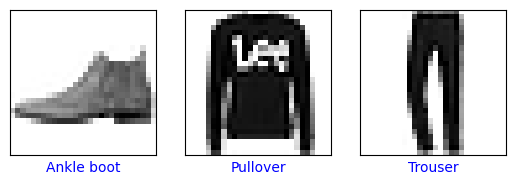

In [5]:
number_of_predictions = 3
get_predictions(model, number_of_predictions)

# Scan the Safe Model 

The scan results include information on the files scanned, and any issues if found. For the safe model scanned, modelscan finds no model serialization attacks, as expected.

In [9]:

!chcp 65001 
import sys
import io
import os
#os.environ['PYTHONIOENCODING'] = 'utf-8'
!modelscan --path PyTorchModels/safe_model.pt

Active code page: 65001
No settings file detected at C:\Users\simant.asawale\Desktop\ProtectAI\modelscan\notebooks\modelscan-settings.toml. Using defaults. 

Scanning C:\Users\simant.asawale\Desktop\ProtectAI\modelscan\notebooks\PyTorchModels\safe_model.pt:safe_model\data.pkl using modelscan.scanners.PickleUnsafeOpScan model scan

--- Summary ---

 No issues found! ðŸŽ‰

--- Skipped --- 

Total skipped: 207 - run with --show-skipped to see the full list.


2024-09-16 17:35:00.598485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-16 17:35:01.464500: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Model Serialization Attack

Here malicious code is injected in the safe model to read aws secret keys. The unsafe model is saved at `./TensorFlowModels/unsafe_model`

In [14]:
unsafe_model_path = os.path.join(model_directory, "unsafe_model.keras")
class MaliciousModule(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(MaliciousModule, self).__init__(**kwargs)
        # Your initialization logic here
    
    def call(self, inputs):
        # Your layer's logic here
        return inputs

    def get_config(self):
        # Return the config for deserialization
        config = super(MaliciousModule, self).get_config()
        return config
    
    @classmethod
    def from_config(cls, config):
        # Recreate the layer from the config
        return cls(**config)
unsafe_model.save("path_to_model", custom_objects={'MaliciousModule': MaliciousModule})

unsafe_model = MaliciousModule(model)
unsafe_model.build(input_shape=(None, 28,28))

# Save the unsafe model

unsafe_model.save(unsafe_model_path)

ValueError: The following argument(s) are not supported: ['custom_objects']

# Unsafe Model Prediction

The malicious code injected in the unsafe model gets executed when it is loaded. The aws secret keys are displayed. 

Also, the unsafe model predicts the clothing items just as well as safe model i.e., the code injection attack will not impact the model performance. The unaffected performance of unsafe models makes the ML models an effective attack vector. 

In [12]:
unsafe_model_loaded = tf.keras.models.load_model(unsafe_model_path, custom_objects={'MaliciousModule': MaliciousModule})


number_of_predictions = 3
get_predictions(unsafe_model_loaded, number_of_predictions)

TypeError: <class 'utils.tensorflow_codeinjection.MaliciousModule'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'utils.tensorflow_codeinjection', 'class_name': 'MaliciousModule', 'config': {'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}, 'registered_name': 'MaliciousModule', 'build_config': {'input_shape': [None, 28, 28]}}.

Exception encountered: Unable to revive model from config. When overriding the `get_config()` method, make sure that the returned config contains all items used as arguments in the  constructor to <class 'utils.tensorflow_codeinjection.MaliciousModule'>, which is the default behavior. You can override this default behavior by defining a `from_config(cls, config)` class method to specify how to create an instance of MaliciousModule from its config.

Received config={'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}}

Error encountered during deserialization: MaliciousModule.__init__() got an unexpected keyword argument 'trainable'

# Scan the Unsafe Model

The scan results include information on the files scanned, and any issues if found. In this case, a critical severity level issue is found in the unsafe model scanned. 

modelscan also outlines the found operator(s) and module(s) deemed unsafe. 

In [9]:
!modelscan -p TensorFlowModels/unsafe_model

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/fingerprint.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/saved_model.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan

--- Summary ---

Total Issues: 2

Total Issues By Severity:

    - LOW: 0
    - MEDIUM: 0
    - HIGH: 2
    - CRITICAL: 0

--- Issues by Severity ---

--- HIGH ---

Unsafe operator found:
  - Severity: HIGH
  - Description: Use of unsafe operator 'ReadFile' from module 'Tensorflow'
  - Source: /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/sav

# Reporting Format
ModelScan can report scan results in console (default), JSON, or custom report (to be defined by user in settings-file). For mode details, please see:  ` modelscan -h` 

## JSON Report

For JSON reporting: `modelscan -p ./path-to/file -r json -o output-file-name.json` 

In [10]:
# This will save the scan results in file: tensorflow-model-scan-results.json
!modelscan --path  TensorFlowModels/unsafe_model -r json -o tensorflow-model-scan-results.json

No settings file detected at /Users/mehrinkiani/Documents/modelscan/notebooks/modelscan-settings.toml. Using defaults. 

Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/fingerprint.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/keras_metadata.pb using modelscan.scanners.SavedModelLambdaDetectScan model scan
Scanning /Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model/saved_model.pb using modelscan.scanners.SavedModelTensorflowOpScan model scan
{"modelscan_version": "0.5.0", "timestamp": "2024-01-25T17:56:46.559473", 
"input_path": 
"/Users/mehrinkiani/Documents/modelscan/notebooks/TensorFlowModels/unsafe_model"
, "total_issues": 2, "summary": {"total_issues_by_severity": {"LOW": 0, 
"MEDIUM": 0, "HIGH": 2, "CRITICAL": 0}}, "issues_by_severity": {"HIGH": 
[{"description": "Use of unsafe operator 'ReadFile' from modu